In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# from colabtools import adhoc_import  (only needed inside Google)
from contextlib import ExitStack

from fun_mc import using_jax as fun_mc

# ADHOC = True
# CLIENT = 'fig-export-fig_tree-change-451-3e0a679e9746'

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

2024-03-20 11:48:47.371898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Unimodal target

In [3]:

dist = tfd.Normal(0., 1.)
n_chains = 16384  # 10240
n_super_chains = 128  # 8
n_steps = 100
num_samples = 10000
n_sub_chains = n_chains // n_super_chains

def target_log_prob_fn(x):
  return dist.log_prob(x), ()


def kernel(hmc_state, seed):
  hmc_seed, seed = jax.random.split(seed)
  hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
      hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      step_size=0.5,
      num_integrator_steps=1,
      seed=hmc_seed)
  return (hmc_state, seed), (hmc_state.state, hmc_extra.is_accepted)

# Draw sample from a standard normal with an offset to introduce some bias
offset = 2
init_x = dist.sample([n_chains], seed=jax.random.PRNGKey(0)) + offset

_, (chain, is_accepted) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x,
    target_log_prob_fn), jax.random.PRNGKey(0)), kernel, num_samples)

init_x2 = dist.sample([n_super_chains], seed=jax.random.PRNGKey(3))
init_x2 = jnp.repeat(init_x2, n_sub_chains)
#init_x2 = dist.sample([num_chains], seed=jax.random.PRNGKey(3))
init_x2 = init_x2.reshape([n_super_chains, n_sub_chains])

_, (chain2, is_accepted2) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x2,
    target_log_prob_fn), jax.random.PRNGKey(3)), kernel, num_samples)

chain = jnp.concatenate([init_x[jnp.newaxis], chain], 0)
chain2 = jnp.concatenate([init_x2[jnp.newaxis], chain2], 0)
chain3 = chain.reshape(num_samples + 1, -1, n_sub_chains)

In [5]:
between_reg = (jnp.cumsum(chain, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis]).var(1)
#between_reg = (jnp.cumsum(chain2, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis, jnp.newaxis]).var((1, 2))
super_chain = chain2.mean(-1)
between_nested = (jnp.cumsum(super_chain, 0) / jnp.arange(1, super_chain.shape[0] + 1)[:, jnp.newaxis]).var(1)

super_chain_naive = chain3.mean(-1)
between_nested_naive = (jnp.cumsum(super_chain_naive, 0) / jnp.arange(1, super_chain_naive.shape[0] + 1)[:, jnp.newaxis]).var(1)

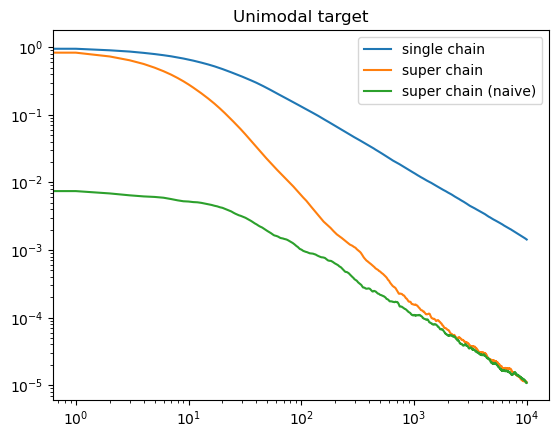

In [6]:
plt.title('Unimodal target')
plt.plot(between_reg, label='single chain')
plt.plot(between_nested, label='super chain')
# plt.plot(between_reg / n_sub_chains, label='single chain / ')
plt.plot(between_nested_naive, label = 'super chain (naive)')
# plt.axhline(1e-2, ls='--', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
# plt.xlabel('chain length')
plt.legend()

In [8]:
# Store to create plots later
between_reg_uni = between_reg
between_nested_uni = between_nested
between_nested_naive_uni = between_nested_naive

## Bimodal target
We now target a bimodal distribution with well-seperated modes $0.3 N(-10, 1) + 0.7 N(10, 1)$.

In [9]:
n_chains = 16384 # 4096
n_super_chains = 128  # 32
n_sub_chains = n_chains // n_super_chains
num_samples = 10000

dist_mix = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=[0.3, 0.7]), 
    components_distribution=tfd.Normal(
      loc=[-5, 5],
      scale=[1, 1]))

def target_log_prob_fn(x):
  return dist_mix.log_prob(x), ()


def kernel(hmc_state, seed):
  hmc_seed, seed = jax.random.split(seed)
  hmc_state, hmc_extra = fun_mc.hamiltonian_monte_carlo_step(
      hmc_state,
      target_log_prob_fn=target_log_prob_fn,
      step_size= 0.5,
      num_integrator_steps=1,
      seed=hmc_seed)
  return (hmc_state, seed), (hmc_state.state, hmc_extra.is_accepted)

# Draw initialization from a normal with a large variance
init_x = 20 * dist.sample([n_chains], seed=jax.random.PRNGKey(1))

_, (chain, is_accepted) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x,
    target_log_prob_fn), jax.random.PRNGKey(0)), kernel, num_samples)

# Now enforce all chains within a superchain to start at the same point.
init_x2 = 20 * dist.sample([n_super_chains], seed=jax.random.PRNGKey(5))
init_x2 = jnp.repeat(init_x2, n_sub_chains)
init_x2 = init_x2.reshape([n_super_chains, n_sub_chains])

_, (chain2, is_accepted2) = fun_mc.trace((fun_mc.hamiltonian_monte_carlo_init(init_x2,
    target_log_prob_fn), jax.random.PRNGKey(3)), kernel, num_samples)

chain = jnp.concatenate([init_x[jnp.newaxis], chain], 0)
chain2 = jnp.concatenate([init_x2[jnp.newaxis], chain2], 0)
chain3 = chain.reshape(num_samples + 1, -1, n_sub_chains)

Text(0.5, 0, 'chain length')

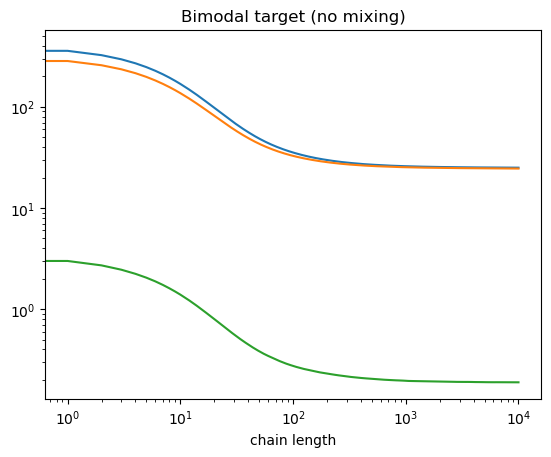

In [11]:
between_reg = (jnp.cumsum(chain, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis]).var(1)
#between_reg = (jnp.cumsum(chain2, 0) / jnp.arange(1, chain.shape[0] + 1)[:, jnp.newaxis, jnp.newaxis]).var((1, 2))
super_chain = chain2.mean(-1)
between_nested = (jnp.cumsum(super_chain, 0) / jnp.arange(1, super_chain.shape[0] + 1)[:, jnp.newaxis]).var(1)

super_chain_naive = chain3.mean(-1)
between_nested_naive = (jnp.cumsum(super_chain_naive, 0) / jnp.arange(1, super_chain_naive.shape[0] + 1)[:, jnp.newaxis]).var(1)

plt.title('Bimodal target (no mixing)')
plt.plot(between_reg, label='single chain')
plt.plot(between_nested, label='super chain')
plt.plot(between_nested_naive, label = 'super chain (naive)')
# plt.plot(between_reg / n_sub_chains, label='single chain / ')
# plt.axhline(21, ls = '-', color = 'black')
# plt.axhline(1e-2 * 21, ls='--', color='black', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('chain length')
# plt.legend()

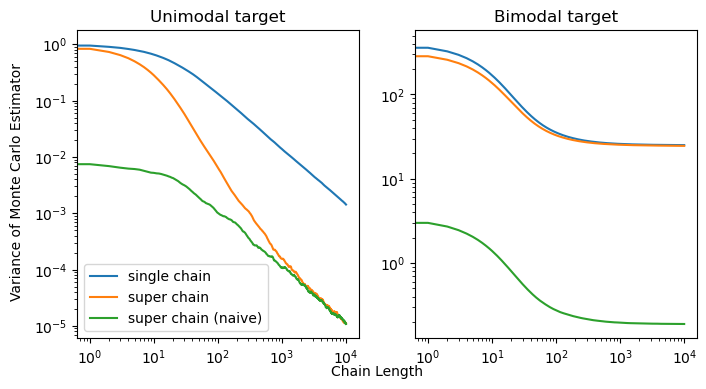

: 

In [15]:

fig, ax = plt.subplots(1, 2, sharey = False, sharex = True,
                   figsize=(8, 4))
ax[0].plot(between_reg_uni, label='single chain')
ax[0].plot(between_nested_uni, label='super chain')
ax[0].plot(between_nested_naive_uni, label = 'super chain (naive)')
ax[0].legend(loc = "lower left")
ax[0].set_title("Unimodal target")

ax[0].set_yscale('log')

ax[1].plot(between_reg, label='single chain')
ax[1].plot(between_nested, label='super chain')
ax[1].plot(between_nested_naive, label = 'super chain (naive)')
ax[1].set_title("Bimodal target")

ax[1].set_xscale('log')
ax[1].set_yscale('log')
# ax[1].set_xlabel('Chain Length')

fig.text(0.05, 0.5, 'Variance of Monte Carlo Estimator', ha='center', va='center', rotation='vertical')
fig.text(0.5, 0.025, "Chain Length", ha="center", va="center")

fig_dir = "/mnt/home/cmargossian/Code/nested-rhat/figures/"
plt.savefig(fig_dir + "nRhat_transient.pdf", bbox_inches='tight')